In [42]:
import collections
import io
import time
import math
import logging
import sys

from scipy import stats

import numpy as np

In [62]:
import os
import collections

evaluation_measures = ['ndcg_cut_10', 'map_cut_1000', 'P_5', 'recall_1000']
eval_algorithms = ['ad_delta_0.1', 'bm25', 'dp_mu_500', 'jm_lambda_0.9', 'ad_delta_0.5', 'dp_mu_1000', 'jm_lambda_0.1', 'tfidf', 'ad_delta_0.9', 'dp_mu_1500', 'jm_lambda_0.5']
test_type = ['results_validation', 'results_test' ]

trec_eval_directory = '../trec_eval' # required dir format: trec_eval(results_test(...),results_validation(...))
scores = collections.defaultdict(lambda : collections.defaultdict(dict))
all_scores = collections.defaultdict(lambda : collections.defaultdict(lambda:collections.defaultdict(dict)))


#GATHERING ALL NECESSARY SCORES
for directory in os.listdir(os.fsencode(trec_eval_directory)):
    for file in os.listdir(os.path.join(os.fsencode(trec_eval_directory), directory)):
        for line in open(os.path.join(os.fsencode(trec_eval_directory), directory,file)):
            evaluation_type, querry, score = line.split()
            if querry == 'all' and evaluation_type in evaluation_measures:
                scores[os.fsdecode(directory)][os.fsdecode(file)[:-4]][evaluation_type] = score
            elif evaluation_type in evaluation_measures:
                all_scores[os.fsdecode(directory)][os.fsdecode(file)[:-4]][evaluation_type][querry] = score


# ADJUSTING THE HYPERPARAMETERS BASED ON VALIDATION SET
val_maxim_algorithms = collections.defaultdict(lambda: collections.defaultdict(lambda: -1.0))
algor_name = collections.defaultdict(lambda: collections.defaultdict(lambda: None))

for eval_algorithm in scores['results_validation'].keys():
    for eval_measure in scores['results_validation'][eval_algorithm].keys():
        if float(scores['results_validation'][eval_algorithm][eval_measure]) > float(val_maxim_algorithms[eval_algorithm.split('_')[0]][eval_measure]):
            val_maxim_algorithms[eval_algorithm.split('_')[0]][eval_measure] = scores['results_validation'][eval_algorithm][eval_measure]
            algor_name[eval_algorithm.split('_')[0]][eval_measure] = eval_algorithm
    
    
# TAKE THE SCORE FROM THE TEST SET BASED ON CHOSEN HYPERPARAMETERS
test_maxim_algorithms = collections.defaultdict(lambda: collections.defaultdict(lambda: -1.0))

for eval_algorithm in val_maxim_algorithms.keys():
    for eval_measure in val_maxim_algorithms[eval_algorithm].keys():
        test_maxim_algorithms[eval_algorithm][eval_measure] = scores['results_test'][algor_name[eval_algorithm][eval_measure]][eval_measure]

all_scores

defaultdict(<function __main__.<lambda>>,
            {'results_test': defaultdict(<function __main__.<lambda>.<locals>.<lambda>>,
                         {'ad_delta_0.1': defaultdict(dict,
                                      {'P_5': {'100': '0.0000',
                                        '51': '0.2000',
                                        '52': '0.0000',
                                        '54': '0.2000',
                                        '55': '0.0000',
                                        '56': '0.0000',
                                        '58': '0.0000',
                                        '59': '0.0000',
                                        '60': '0.0000',
                                        '61': '0.0000',
                                        '62': '0.0000',
                                        '63': '0.0000',
                                        '64': '0.0000',
                                        '65': '0.0000',
                 

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

class ExperimentSetup:
    def __init__(self, name, param_name, parameters, values):
        self.name = name
        self.param_name = param_name
        self.parameters = parameters
        self.values = values
        
language_models = ['jm','dp','ad','plm']
graph_data = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
for key in scores['results_test'].keys():
    if key.split('_')[0] in language_models:
        graph_data[key.split('_')[0]]['values'].append(float(scores['results_test'][key]['ndcg_cut_10']))
        graph_data[key.split('_')[0]]['parameters'].append(key.split('_')[-1])

for key in graph_data.keys():
    graph_data[key]['parameters'] = np.array(graph_data[key]['parameters'], dtype=float)  # form array to numpy.array
    sort_indexes = np.argsort(graph_data[key]['parameters'])
    graph_data[key]['parameters'] = graph_data[key]['parameters'][sort_indexes]  # sort
    graph_data[key]['values'] = np.array(graph_data[key]['values'], dtype=float)[sort_indexes] # form array to numpy.array and sort
    
    
        
experiments = [ExperimentSetup("Jelinek-Mercer","λ",graph_data['jm']['parameters'],graph_data['jm']['values']),
                ExperimentSetup("Dirichlet Prior","μ",graph_data['dp']['parameters'],graph_data['dp']['values']),
                ExperimentSetup("Absolute Discounting","δ",graph_data['ad']['parameters'],graph_data['ad']['values']),
              ExperimentSetup("Positional Language Model","μ",graph_data['plm']['parameters'],graph_data['plm']['values'])]

# ExperimentSetup("Positional Language Model","μ",graph_data['plm']['parameters'],graph_data['jm']['values'])

def plot_results(experiments):
    ax = plt.subplot(111)
    ax.get_xaxis().set_visible(True)
    bar_width = 1
    
    plt.title('NDCG@10')
    
    mm = ''
    for ex in experiments:
        mm = mm + ex.name + "=" + ex.param_name + "\n"
    ax.annotate(mm, xy=(0.05,0.5),xycoords='axes fraction',
             fontsize=14)
    

    label_x = []
    label_values = []
    padding=0

    for algorithm_index, experiment in enumerate(experiments):
        bars = np.arange(0,bar_width*(len(experiment.parameters)+1),bar_width)[:len(experiment.parameters)]
        mean = bars.mean()
        bars = bars - mean

        colors = ['indianred', 'red','maroon']
        rects1 = ax.bar(bars + padding, experiment.values, width = bar_width, color=colors, align='center')
        
        label_x.append(padding)
        label_values.append(experiment.name)
        
        padding += (bar_width*len(experiment.parameters)+bar_width) 
        
#       Attach a text label above each bar displaying its paramtere
        for index, rect in enumerate(rects1):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%s' % experiment.parameters[index],
                    ha='center', va='bottom')
    plt.xticks(label_x, label_values, rotation='10')
    
    plt.show()

The following tables contains the scores for each of the evaluation measures, evaluated on the validation set:

|    Absolute Discounting    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| delta=0.1 |0.1885 |0.1422 | 0.1833|0.3314 |
| delta=0.5 |0.1941 |0.1446 |0.1833 | 0.3334|
| delta=0.9 | 0.1944|0.1459 | 0.1833 |0.3322 |

|    Dirichlet Prior    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| mu=500 |0.2235 |0.1453 | 0.2167|0.3322 |
| mu=1000 |0.2195 |0.1454 |0.2333 | 0.3293|
| mu=1500 | 0.2192|0.1457 | 0.2333 |0.3268 |

|    Jelinek-Mercer    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| lambda=0.1 |0.1888 |0.1418 | 0.1833|0.3240 |
| lambda=0.5 |0.1888 |0.1416 |0.1833 | 0.3295|
| lambda=0.9 | 0.1888|0.1416 |0.1833 |0.3310 |

|    Positional Language Model    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| mu=1000 |0.2642 |0.1489 | 0.2500|0.3412 |
                           
|    TD-IDF    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
|  |0.3548 |0.2420 | 0.3500|0.7203 |

|    BM25    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
|  |0.3232 |0.2582 | 0.3167|0.7249 |


Having the information in the tables above, the report of evaluation measures using the optimised hyperparameters can be found in the following table(the hyperparameter can be found between paranthesis):

|    Jelinek-Mercer    | NDCG@10   | MAP@1000 | Precision@5 | Recall@1000 |
|--------|-----------|----------|-------------|-------------|
| TD-IDF |0.3973(--)|0.1979(--)|0.4000(--)|0.5542(--)|
| BM25 (k1=1.2, b=0.75) |0.3689|0.1957|0.3526|0.5623|
| Jelinek-Mercer |0.0480(0.1)|0.0264(0.1)|0.0526(0.1)|0.1889(0.9)|
| Dirichlet Prior |0.0863(500)|0.0330(1500)|0.1000(1000)|0.1877(500)|
| Absolute Discounting |0.0588(0.9)|0.0295(0.9)|0.0526(0.1)|0.1939(0.5)|
| Positional Language Model |0.3136(1000)|0.1113(1000)|0.3263(1000)|0.2589(1000)|

Given that for the Positional Language Model the training of the model needs too much resources in terms of time, we run it once with $\mu = 1000$, and only on the first 50 querries. In consequence, for a better comparison, all other language models were trained on the first 50 querries as well.

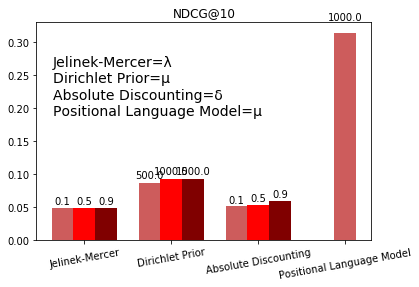

In [37]:
plot_results(experiments)

Compute significance of the results using a two-tailed paired Student t-test [5 points]. Be wary of false rejection of the null hypothesis caused by the multiple comparisons problem. There are multiple ways to mitigate this problem and it is up to you to choose one.

In [83]:
#GET NECESSARY DATA.
chosen = collections.defaultdict(lambda: collections.defaultdict(dict))
# all_scores['results_test']['ad_delta_0.1']
for alg in algor_name.keys():
    for metric in algor_name[alg].keys():
        chosen[metric][alg] = all_scores['results_test'][algor_name[alg][metric]][metric]
        sorted_querries = np.sort(np.array(list(chosen[metric][alg].keys()), dtype=int))
        chosen[metric][alg]=[chosen[metric][alg][str(querry)] for querry in sorted_querries]
        
rez = collections.defaultdict(lambda: collections.defaultdict(dict))
for metric in chosen.keys():
    for algorithm1 in chosen[metric].keys():
        for algorithm2 in chosen[metric].keys():
            if algorithm1 != algorithm2:
                s,p = stats.ttest_rel(np.array(chosen[metric][algorithm1], dtype=float),np.array(chosen[metric][algorithm2], dtype=float))
                rez[metric][(min(algorithm1,algorithm2),max(algorithm1,algorithm2))] = (s,p)
                
rez


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


defaultdict(<function __main__.<lambda>>,
            {'P_5': defaultdict(dict,
                         {('ad', 'bm25'): (5.1451728199624487,
                           8.9998580329673762e-06),
                          ('ad', 'dp'): (2.4756482698130244,
                           0.0180015414014855),
                          ('ad', 'jm'): (nan, nan),
                          ('ad', 'lda'): (3.1599235022857228,
                           0.0031413152596349329),
                          ('ad', 'lsi'): (3.0481625026984935,
                           0.0042350783380713537),
                          ('ad', 'plm'): (4.7469288317114398,
                           3.0746573816945531e-05),
                          ('ad', 'tfidf'): (5.3287286323483691,
                           5.0893205008173851e-06),
                          ('bm25', 'dp'): (-4.1968110680010193,
                           0.00016270132233752423),
                          ('bm25', 'jm'): (-5.1451728199624487,
        

In [79]:
fdf = {}

fdf[('ana','b')]=2
fdf

{('ana', 'b'): 2}

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is very important in order to understand who the different retrieval functions behave.